# Investigating some common optimization methods for deep learning (15 points)

### HW1 @ DL Course, Dr. Soleymani

*Full Name:* Amir Mohammad Ezzati

*SID:* 402212269

## Introduction

In this notebook, we explore several optimization methods commonly employed in deep learning tasks and assess their effectiveness using two test functions. Our aim is to provide you with insights into how these methods operate.

Do NOT forget that gaining insights is highly dependent to your patience of re-runing methods with different hyperparameters and observing the corresponding result.

**Note:** You don't need GPU for this notebook. Save it for a rainy day!

In [ ]:
#@title Imports
import torch
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython import display

display.clear_output()

## Test functions for optimization
In practical terms, when assessing the effectiveness of different optimization algorithms and hyperparameters, our primary concern lies in their performance across a diverse set of real-world challenges, particularly in optimizing a loss function. However, visualizing the actions of our algorithms may be challenging due to the complex, high-dimensional nature of loss landscapes, even with relatively simple neural networks trained on real-world datasets. To address this issue, various test functions have been proposed to provide insight into the scenarios that optimization algorithms may encounter.

In this notebook we use **Ackley function** and **Beale function**. You can refer to [this wikipedia page](https://en.wikipedia.org/wiki/Test_functions_for_optimization) to find formulas of these functions.



```
# This is formatted as code
```

**TO DO:** implement ackley and beale functions. Your output must be a pytorch tensor.

In [ ]:
def ackley(x, y):
    ######### Your code goes here #########
    term1 = - 20 * torch.exp(-0.2 * torch.sqrt(0.5 * (x**2 + y**2)))
    term2 = - torch.exp(0.5 * (torch.cos(2 * torch.pi * x) + torch.cos(2 * torch.pi * y)))
    return term1 + term2 + 20 + torch.tensor(np.e)
    #######################################

In [ ]:
def beale(x, y):
    ######### Your code goes here #########
    term1 = 1.5 - x + x * y
    term2 = 2.25 - x + x * y**2
    term3 = 2.625 - x + x * y**3
    return term1 ** 2 + term2 ** 2 + term3 ** 2
    #######################################

In [ ]:
#@title Helper functions for ploting (JUST RUN THIS)

def gen_2d_loss_surface(loss_func,
             n_x=100, # number of discretization points along the x-axis
             n_y=100, # number of discretization points along the x-axis
             min_x=-0.5, max_x=3.5, # extreme points in the x-axis
             min_y=-1.5, max_y=1.5 # extreme points in the y-axis
            ):

  # create a mesh of points at which to evaluate our function
  X, Y = torch.meshgrid(torch.linspace(min_x, max_x, n_x), torch.linspace(min_y, max_y, n_y), indexing='xy')

  # evaluate the func at all of the points
  Z = loss_func(X, Y).numpy()

  return X, Y, Z


def make_contour_plot(X, Y, Z, levels=None):
  if levels == None:
    # generate 20 levels on a log scale
    levels = np.insert(np.logspace(0, 2.6, 40, True, base=10), 0, 0)

  fig = plt.figure(figsize=(10, 3))
  ax = fig.gca()

  ax.contour(X, Y, Z, levels, alpha=0.5)
  ax.contourf(X, Y, Z, levels, alpha=0.2)
  ax.set_xlabel('x')
  ax.set_ylabel('y')

  return fig, ax


def make_surface_plot(X, Y, Z, elevation=0, azimuth_angle=0, levels=None):

  if levels == None:
    # generate 20 levels on a log scale
    levels = np.insert(np.logspace(0, 2.6, 40, True, base=10), 0, 0)

  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(projection='3d')
  ax.view_init(elevation, azimuth_angle)
  ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.2)
  ax.contour(X, Y, Z, levels, cmap='viridis', alpha=0.5)

  ax.set_xlabel('x')
  ax.set_ylabel('y')

  return fig, ax

### Ploting the test functions
Run the following cells provided for you to gain some intution about the landscape of ackley and beale functions

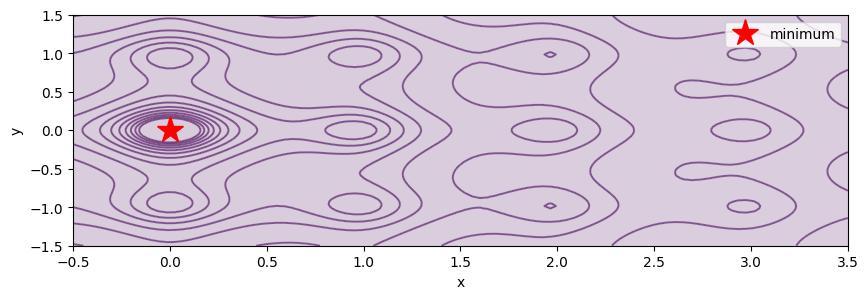

In [ ]:
X, Y, Z = gen_2d_loss_surface(ackley)
fig, ax = make_contour_plot(X, Y, Z)

ax.plot(0, 0, 'r*', ms=20, label='minimum')
ax.legend();

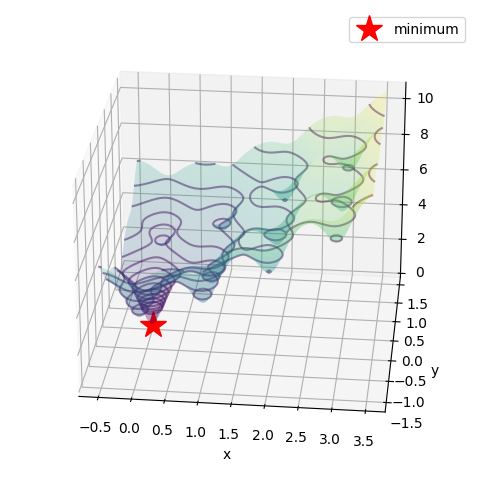

In [ ]:
#@title {run: "auto"}
elevation = 25 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 276 #@param {type:"slider", min:0, max:360, step:1}

X, Y, Z = gen_2d_loss_surface(ackley)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([0], [0], 'r*', zs=[0], zdir='z', ms=20, label='minimum')
ax.legend();

As you can see, the ackley function is highly non-convex with multiple local minimas, which makes this a useful function for testing optimization algorithms.

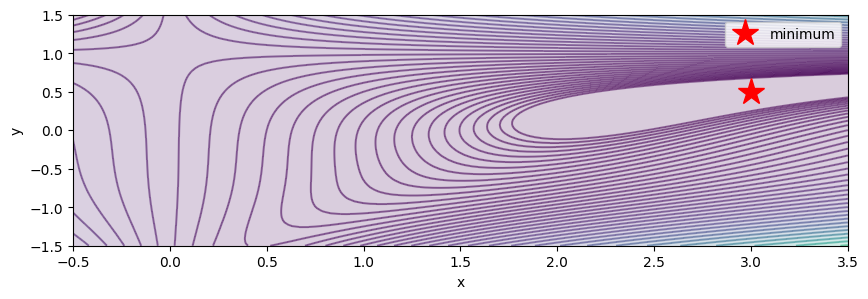

In [ ]:
X, Y, Z = gen_2d_loss_surface(beale)
fig, ax = make_contour_plot(X, Y, Z)

ax.plot(3, 0.5, 'r*', ms=20, label='minimum')
ax.legend();

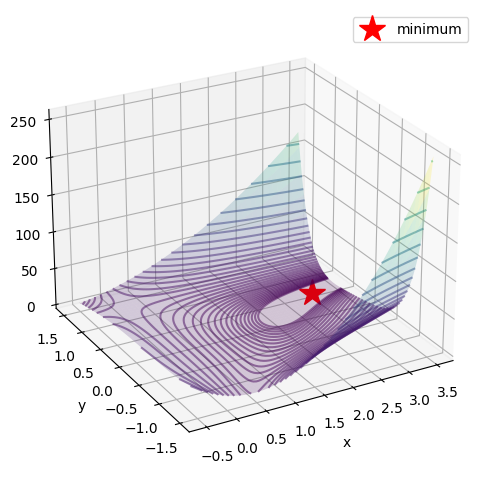

In [ ]:
#@title {run: "auto"}
elevation = 25 #@param {type:"slider", min:0, max:360, step:1}
azimuth_angle = 241 #@param {type:"slider", min:0, max:360, step:1}

X, Y, Z = gen_2d_loss_surface(beale)
fig, ax = make_surface_plot(X, Y, Z, elevation, azimuth_angle)

ax.plot([3], [0.5], 'r*', zs=[0], zdir='z', ms=20, label='minimum')
ax.legend();

As you can see, within the valley, we have a global minimum. Finding the valley is relatively easy, but finding the global minimum is difficult, which makes this a useful function for testing optimization algorithms.

## Optimization
In this section you will implement one step parameters update of some common optimization methods used in deep learning, and apply them trying to optimize ackley and beale functions.

**TO DO:** For both cases of first_order and second_order methods, implement the parameters update in **optimize_loss** function below.

In [ ]:
def optimize_loss(loss_func, update_func, params, states, hyper_params, is_first_order):
  # plot the loss surface, minimum value and starting point
  X, Y, Z = gen_2d_loss_surface(loss_func)
  fig, ax = make_contour_plot(X, Y, Z)
  if loss_func == ackley:
    ax.plot(0, 0, 'r*', ms=20, label='minimum')
  elif loss_func == beale:
    ax.plot(3, 0.5, 'r*', ms=20, label='minimum')
  ax.plot(start_x, start_y, 'b*', ms=20, label='start')

  for epoch in range(epochs):
    loss = loss_func(x, y)

    # save the old x and y values for the plot
    old_x = params[0].detach().numpy().copy()
    old_y = params[1].detach().numpy().copy()

    # update the parameters based on the order of the optimization method
    if is_first_order:
      # calculate the gradients of the loss with respect to the params
      ######### Your code goes here #########
      grads = torch.autograd.grad(loss, params)
      #######################################
      update_func(params, grads, states, hyper_params)

    else:
      # calculate the gradients of the loss with respect to the params
      # then calculate the hessian matrix of the loss with respect to the params
      ######### Your code goes here #########
      grads = torch.autograd.grad(loss, params, create_graph=True)
      hessian = torch.autograd.functional.hessian(loss_func, params)
      #######################################
      update_func(params, grads, hessian, states, hyper_params)

    # plot the change in x and y for each update step
    ax.annotate('', xy=(x.detach().numpy().copy(), y.detach().numpy().copy()),
                xytext=(old_x, old_y),
              arrowprops={'arrowstyle': '->', 'color': 'k', 'lw': 1},
                   va='center', ha='center')

  ax.plot(x.detach().numpy(), y.detach().numpy(), 'g*', ms=20, label='end')
  ax.legend();

### Gradient descent
Gradient descent is the simplest of training algorithms commonly used in deep learning. However, it gives excellent results in many cases, and also forms the basis for many other powerful optimization methods - such as Momentum, RMSProp, and Adam - which we will look at later in this notebook. Mathematically we can describe gradient descent as follows:

\begin{equation}
\mathbf{θ}= \mathbf{θ} −\eta \times \nabla_\mathbf{θ} J(\mathbf{θ})
\end{equation}

where $\mathbf{θ}$ are the parameters of the model, $\eta$ (eta) is the learning rate, $J(\mathbf{θ})$ is the loss (also called $\mathcal{L}$), and $\nabla_\theta J(\mathbf{θ})$ is the **gradient** of the loss with respect to the parameters. This equation tells us that to update each of the parameters, we scale the gradient for each parameter by the learning rate and subtract it from the corresponding parameter.

**TO DO:** Implement one step update of gradient descent.

In [ ]:
def GD_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01
  # GD doesn't have any state, so you don't need it here
  for param, grad in zip(params, grads):
    ######### Your code goes here #########
    param.data = param.data - hyper_params['lr'] * grad
    #######################################

Try different hyperparameters using the sliders below to gain some insights about the performance of the optimization method in diverse situations.

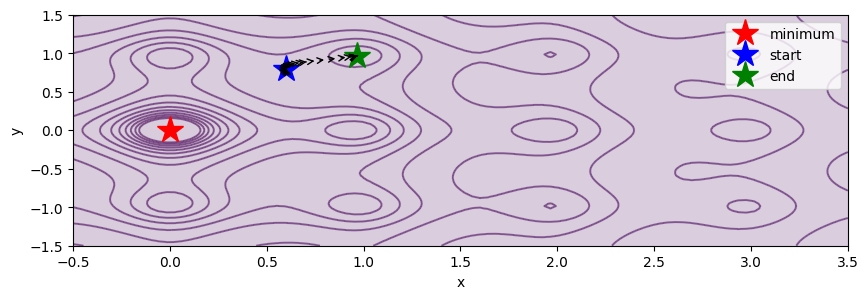

In [ ]:
#@title {run: "auto"}
start_x = 0.6 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.8  #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.015 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
states = []
hyper_params = {"lr": learning_rate}

optimize_loss(ackley, GD_update, params, states, hyper_params, is_first_order)

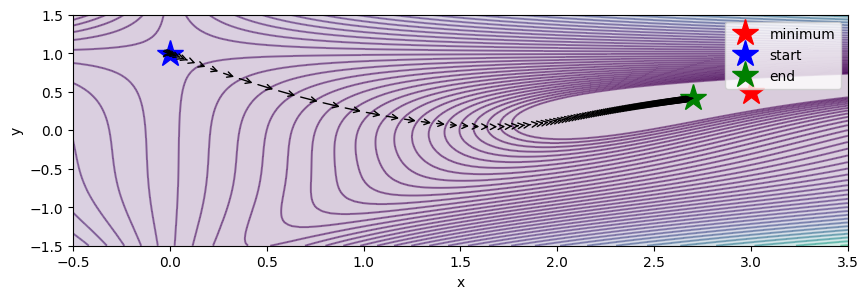

In [ ]:
#@title {run: "auto"}
start_x = 0. #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.99  #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.015 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
states = []
hyper_params = {"lr": learning_rate}

optimize_loss(beale, GD_update, params, states, hyper_params, is_first_order)

### Momentum
When the gradient is small the changes to the parameters become very small and progress towards the minimum is very slow. One solution to this problem is to add a momentum term to our optimization step:

\begin{align}
\Delta \mathbf{θ} &= \gamma \Delta \mathbf{θ} + \eta \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf{θ} &= \mathbf{θ} − \Delta \mathbf{θ}
\end{align}

where $\Delta \mathbf{θ}$ is the change in parameters $\mathbf{θ}$ at each step and is made up of a mixture between the gradients at a given step and the change from the previous step. $\gamma$ (gamma) is called the *momentum* term, and $\eta$ is called the learning rate, as before.

**The momentum term speeds up optimization if the direction of change stays more or less the same and reduces oscillations when the direction of change goes back and forth.**

**TO DO:** Implement one step update of gradient descent with momentum.

In [ ]:
def momentum_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01, momentum=0.9
  # changes is the same as delta_theta in the above formula
  changes = states['changes']
  for param, grad in zip(params, grads):
    ######### Your code goes here #########
    changes[param]= hyper_params['momentum'] * changes[param] + hyper_params['lr'] * grad
    param.data = param.data - changes[param]
    #######################################

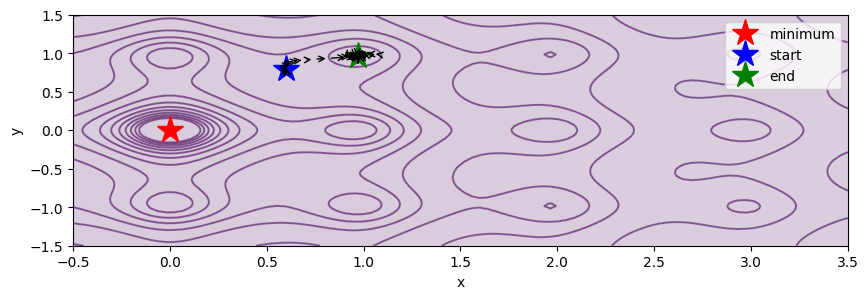

In [ ]:
#@title {run: "auto"}
start_x = 0.6 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.8 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
momentum = 0.8 #@param {type:"slider", min:0, max:0.99, step:0.01}
epochs = 50 #@param {type:"slider", min:1, max:150,step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
changes = {param: torch.tensor(0., dtype=torch.float32) for param in params}
hyper_params = {"lr": learning_rate, "momentum": momentum}
states = {"changes": changes}

optimize_loss(ackley, momentum_update, params, states, hyper_params, is_first_order)

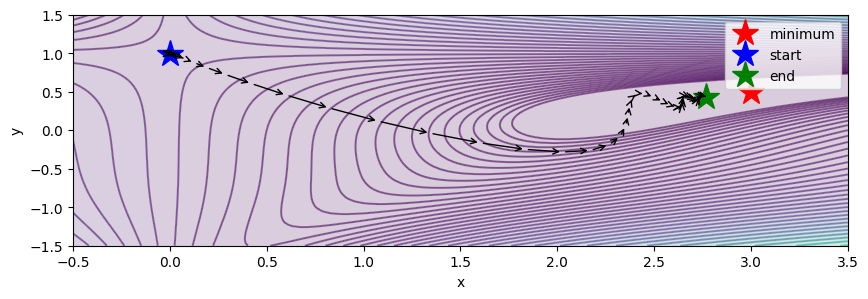

In [ ]:
#@title {run: "auto"}
start_x = 0. #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.99 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
momentum = 0.8 #@param {type:"slider", min:0, max:0.99, step:0.01}
epochs = 50 #@param {type:"slider", min:1, max:150,step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
changes = {param: torch.tensor(0., dtype=torch.float32) for param in params}
hyper_params = {"lr": learning_rate, "momentum": momentum}
states = {"changes": changes}

optimize_loss(beale, momentum_update, params, states, hyper_params, is_first_order)

### RMSProp (Root Mean Square Propagation)

Up to this point, we've selected a learning rate $\eta$, which has been uniformly applied to the entire gradient. Consequently, every component within the gradient vector has undergone the same adjustment at each iteration. However, we can imagine scenarios where:

1.   Not every weight necessitates identical adjustments.
2.   The desired modification for each parameter can change over the course of optimization.

RMSProp emerges as a solution to tackle these challenges. It can be described with the following formula:

\begin{align}
\mathbf{v} &= \gamma \mathbf{v} + (1 - \gamma) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{v}} + \mathbf{\epsilon}} \nabla_\mathbf{θ} J(\mathbf{θ})
\end{align}

where each element of $\mathbf{v}$ is an estimate of the square of the gradient for a specific parameter, calculated using a rolling average, $\gamma$ is a forgetting factor for the rolling average, and $\mathbf{\epsilon}$ (epsilon) is a small number added for numerical stability.

In other words, RMSProp is scaling down the learning rate for each gradient by rolling average of the most recent gradients for that parameter. Importantly **each parameter has its own learning rate, which changes over time**.

**TO DO:** Implement one step update of RMSProp.

In [ ]:
def RMSProp_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.001, gamma=0.9, eps=1e-8
  # averages is the same as v in the above formula
  averages = states['averages']
  for param, grad in zip(params, grads):
    ######### Your code goes here #########
    averages[param] = hyper_params['gamma'] * averages[param] + (1 - hyper_params['gamma']) * grad**2
    param.data = param.data - (hyper_params['lr'] * grad / (torch.sqrt(averages[param]) + hyper_params['eps']))
    #######################################

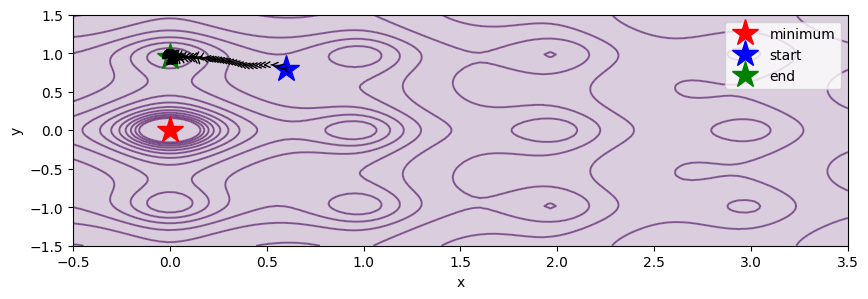

In [ ]:
#@title {run: "auto"}
start_x = 0.6 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.8 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.01 #@param {type:"slider", min:0, max:0.02,step:0.0005}
gamma = 0.9 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
averages = {param: torch.tensor(0., dtype=torch.float32) for param in params}
states = {"averages": averages}
hyper_params = {"lr": learning_rate, "gamma": gamma, "eps": 1e-8}

optimize_loss(ackley, RMSProp_update, params, states, hyper_params, is_first_order)

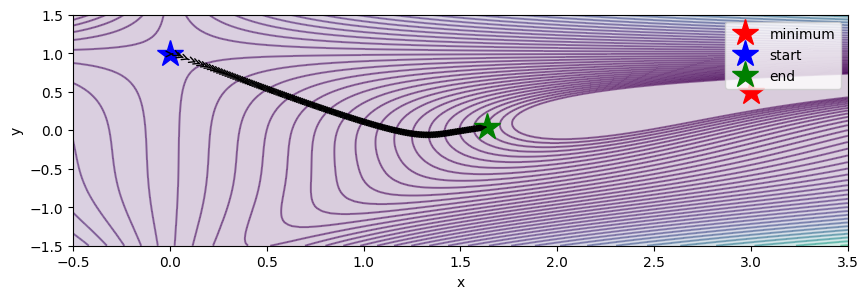

In [ ]:
#@title {run: "auto"}
start_x = 0. #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.99 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.01 # @param {type:"slider", min:0, max:0.02, step:0.001}
gamma = 0.9 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
averages = {param: torch.tensor(0., dtype=torch.float32) for param in params}
states = {"averages": averages}
hyper_params = {"lr": learning_rate, "gamma": gamma, "eps": 1e-8}

optimize_loss(beale, RMSProp_update, params, states, hyper_params, is_first_order)

### Adam (Adaptive moment estimation)

Adam combines the ideas of momentum and adaptive learning rates that we have explored above. More specifically, in addition to storing the rolling averages of the *squared* gradients and using them to control the learning rate for each parameter, like RMSProp, it also stores the rolling averages of the gradients themselves and uses them like momentum. Mathematically, we can describe Adam as follows:

\begin{align}
\mathbf m &= β_1 \mathbf{m} + (1 − β_1)  \nabla_\mathbf{θ} J(\mathbf{θ}) \\
\mathbf v &= β_2 \mathbf{v} + (1 − β_2) (\nabla_\mathbf{θ} J(\mathbf{θ}))^2 \\
\mathbf{\hat{m}} &= \frac{\mathbf{m}}{1 − β_1^t} \\
\mathbf{\hat{v}} &= \frac{\mathbf{v}}{1 − β_2^t} \\
\mathbf{θ} &= \mathbf{θ} − \frac{\eta}{\sqrt{\mathbf{\hat{v}}} + \mathbf{\epsilon}} \mathbf{\hat{m}}
\end{align}

where $\mathbf{m}$ is a rolling estimate of the gradient, $\mathbf{v}$ is a rolling estimate of the squared gradient,  $\mathbf{\hat{m}}$ and $\mathbf{\hat{v}}$ are bias-corrected estimates, and the $\beta_i$ (beta) are mixing factors. As before, $\eta$ and $\epsilon$ are the learning rate and a numerical stability term.

**TO DO:** Implement one step update of Adam.

In [ ]:
def Adam_update(params, grads, states, hyper_params):
  # hyper-param typical values: learning_rate=0.001, beta1=0.9, beta2=0.999, eps=1e-8
  t = states["t"]
  t += 1.
  first_moments = states["first_moments"]
  second_moments = states["second_moments"]

  for param, grad in zip(params, grads):
    ######### Your code goes here #########
    first_moments[param]  = hyper_params['beta1'] * first_moments[param]  + (1 - hyper_params['beta1']) * grad
    second_moments[param] = beta2 * second_moments[param] + (1 - hyper_params['beta2']) * grad**2

    m_hat  = first_moments[param]  / (1 - hyper_params['beta1'] ** t)
    v_hat = second_moments[param] / (1 - hyper_params['beta2'] ** t)

    param.data = param.data - (hyper_params['lr'] * m_hat / torch.sqrt(v_hat))
    #######################################


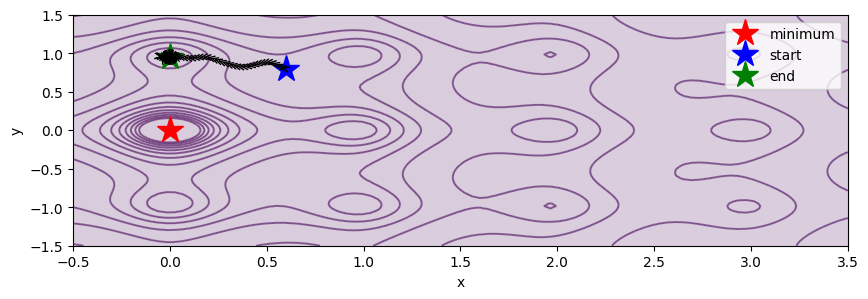

In [ ]:
#@title {run: "auto"}
start_x = 0.6 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.8 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.02 #@param {type:"slider", min:0, max:0.02,step:0.0005}
beta1 = 0.8 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
beta2 = 0.8 #@param {type:"slider", min:0.01, max:0.999, step:0.001}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
first_moments = {param: torch.tensor(0., dtype=torch.float32) for param in params}
second_moments = {param: torch.tensor(0., dtype=torch.float32)for param in params}
t = torch.tensor(0., dtype=torch.float32)
states = {"first_moments": first_moments,
          "second_moments": second_moments, "t": t}
hyper_params = {"lr": learning_rate, "beta1": beta1, "beta2": beta2, "eps": 1e-8}

optimize_loss(ackley, Adam_update, params, states, hyper_params, is_first_order)

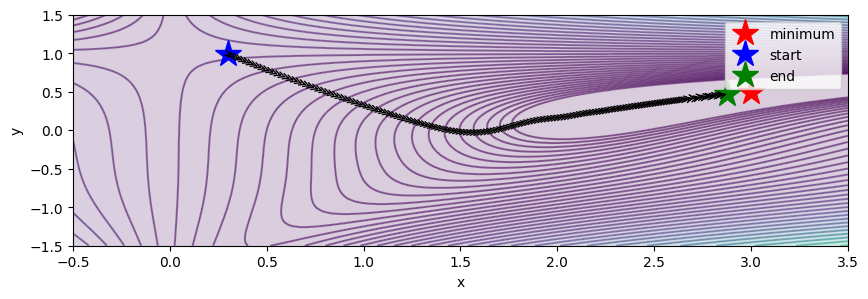

In [ ]:
#@title {run: "auto"}
start_x = 0.3 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.99 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.02 #@param {type:"slider", min:0, max:0.02,step:0.0005}
beta1 = 0.8 #@param {type:"slider", min:0.01, max:0.99, step:0.01}
beta2 = 0.88 #@param {type:"slider", min:0.01, max:0.999, step:0.001}
epochs = 150 #@param {type:"slider", min:1, max:150,step:1}
is_first_order = True

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = [x, y]
first_moments = {param: torch.tensor(0., dtype=torch.float32) for param in params}
second_moments = {param: torch.tensor(0., dtype=torch.float32)for param in params}
t = torch.tensor(0., dtype=torch.float32)
states = {"first_moments": first_moments,
          "second_moments": second_moments, "t": t}
hyper_params = {"lr": learning_rate, "beta1": beta1, "beta2": beta2, "eps": 1e-8}

optimize_loss(beale, Adam_update, params, states, hyper_params, is_first_order)

### Newton method (second order)

The Newton's Method is an iterative second-order optimization algorithm. It's particularly effective when dealing with smooth, twice-differentiable functions.

The main idea behind Newton's Method is to iteratively refine an initial guess of the optimum by using information about the curvature of the function. It approximates the function being optimized with a quadratic approximation around the current guess, then finds the minimum of that quadratic approximation, which is used as the next guess. Mathematicaly we can describe newton method as follows:

\begin{equation}
\mathbf{θ} = \mathbf{θ} - \eta H^{-1}(\mathbf{θ})\nabla_\mathbf{θ} J(\mathbf{θ})
\end{equation}

where $H$ is the hessian matrix of the loss function.

**TO DO:** Implement one step update of Newton method.

In [ ]:
def Newton_update(params, grads, hessian, states, hyper_params):
  # hyper-param typical values: learning_rate=0.01
  # Newton method doesn't have any state, so you don't need it here
    ######### Your code goes here #########
    hessian_inv = torch.inverse(torch.tensor(hessian))
    grads_vec = torch.tensor(grads).reshape(-1, 1)
    delta_params = torch.matmul(hessian_inv, grads_vec)

    for param, delta_param in zip(params, delta_params):
      param.data = param.data - (hyper_params['lr'] * delta_param)
    #######################################

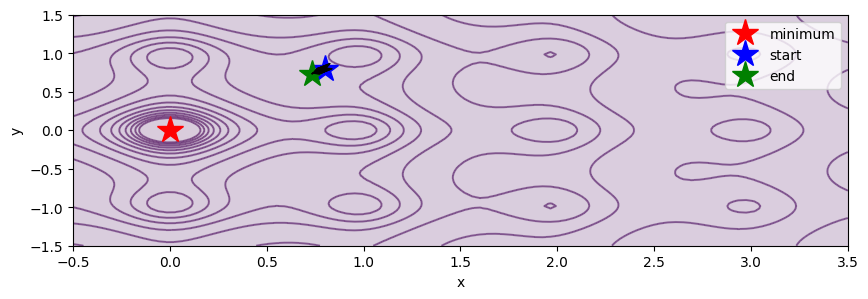

In [ ]:
#@title {run: "auto"}
start_x = 0.8 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.8 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.015 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 52 #@param {type:"slider", min:1, max:150, step:1}
is_first_order = False

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = (x, y)
states = []
hyper_params = {"lr": learning_rate}

optimize_loss(ackley, Newton_update, params, states, hyper_params, is_first_order)

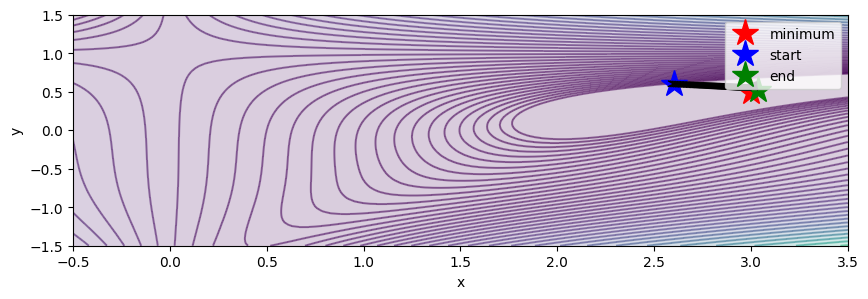

In [ ]:
#@title {run: "auto"}
start_x = 2.6 #@param {type:"slider", min:-0.5, max:3.5, step:0.1}
start_y = 0.6 #@param {type:"slider", min:-1.5, max:1.5, step:0.1}
learning_rate = 0.015 #@param {type:"slider", min:0, max:0.02, step:0.0005}
epochs = 150 #@param {type:"slider", min:1, max:150, step:1}
is_first_order = False

x = torch.tensor(start_x, dtype=torch.float32, requires_grad=True)
y = torch.tensor(start_y, dtype=torch.float32, requires_grad=True)
params = (x, y)
states = []
hyper_params = {"lr": learning_rate}

optimize_loss(beale, Newton_update, params, states, hyper_params, is_first_order)

## Final questions
Please answer the following questions below them.

**1.** How did different optimization methods perform when optimizing the Ackley function, and why?



Ackley is non-convex and complex function which has many local minima that are not a global minima.                 
Adam and RMSprop proved to be more efficient for the Ackley function, as they discovered a better local minimum closer to the global minimum. However, momentum and gradient descent optimizers found a different local minimum, which was closer to the starting point and worse than the one found by Adam and RMSprop. This can be attributed to factors such as adaptive learning rates, approximation of second-order methods, and handling sparse gradients of non-convex function, which enable Adam and RMSprop optimizers to outperform Gradient Descent and Momentum.                        
For non-convex problems, which have multiple local minima, Newton’s method can encounter difficulties. As we observed, the Newton optimizer could not locate any local or global minimum for this function.

**2.** Should we be concerned about similar challenges when optimizing loss functions in deep learning, and why?

Theoretically, local minima can create a significant issue, as it can lead to a suboptimal trained model. In practice, however, the local minima in the error surface of deep learning are not as problematic as they might seem. This is because many of these local minima are equivalent in terms of their performance on the training, testing, and validation datasets. In other words, these models have learned the same thing from the training dataset. Therefore, these local minima are inherently not problematic.       
Recent studies have shown that most of the local minima, including the spurious ones, have an error rate and generalization characteristics very similar to global minima. So even the spurious local minima is not an issue, keeping generalization as our main goal.       
Moreover, ongoing studies suggest that deep learning can be accomplished without encountering poor local minima. This means that although deep learning is more complex than traditional machine learning due to its non-convex loss function, the absence of problematic local minima makes it easier and highly applicable in practice.             